Specific Task 2 (if you are interested in “Diffusion Models for Fast Detector Simulation” project):
* Use a Diffusion Network model to represent the events in task 1. Please show a side-by side comparison of the original and reconstructed events and appropriate evaluation metric of your choice that estimates the difference between the two.


## Importing dependencies

In [1]:
import numpy as np
import h5py
import math
import os
import numpy as np
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn.functional as F

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import h5py
from torchvision import transforms


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset preparation


In [3]:
# Load data from HDF5 file
data_path = "/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5"  # Replace with your own file path

with h5py.File(data_path, 'r') as f:
    print(f"Keys: {list(f.keys())}")
    X_jets = f['X_jets'][0:6400]                   #To work with only a subset of all images due to computational limit
    print(f"X_jets shape: {X_jets.shape}")         # Consists of image data
    # m0 = f["m0"]
    # pt = f["pt"]
    # y = f["y"]
    # print(f"m0 shape: {m0.shape}")               # Mass 
    # print(f"pt shape: {pt.shape}")               # Transverse momentum 
    # print(f"y shape: {y.shape}")                 # Labels 

# print(X_jets.shape)

Keys: ['X_jets', 'm0', 'pt', 'y']
X_jets shape: (6400, 125, 125, 3)


In [4]:
# Normalize Track, ECAL, HCAL data using mean and standard deviation
mean_track = np.mean(X_jets[:,:,:,0])
std_track = np.std(X_jets[:,:,:,0])

mean_ecal = np.mean(X_jets[:,:,:,1])
std_ecal = np.std(X_jets[:,:,:,1])

mean_hcal = np.mean(X_jets[:,:,:,2])
std_hcal = np.std(X_jets[:,:,:,2])

mean = [mean_track, mean_ecal, mean_hcal] 
std = [std_track, std_ecal, std_hcal]

In [5]:
normalized_track = (X_jets[:,:,:,0] - mean_track) / std_track
normalized_ecal = (X_jets[:,:,:,1] - mean_ecal) / std_ecal
normalized_hcal = (X_jets[:,:,:,2] - mean_hcal) / std_hcal


combined = normalized_track + normalized_ecal + normalized_hcal
combined = np.expand_dims(combined, axis=-1) 


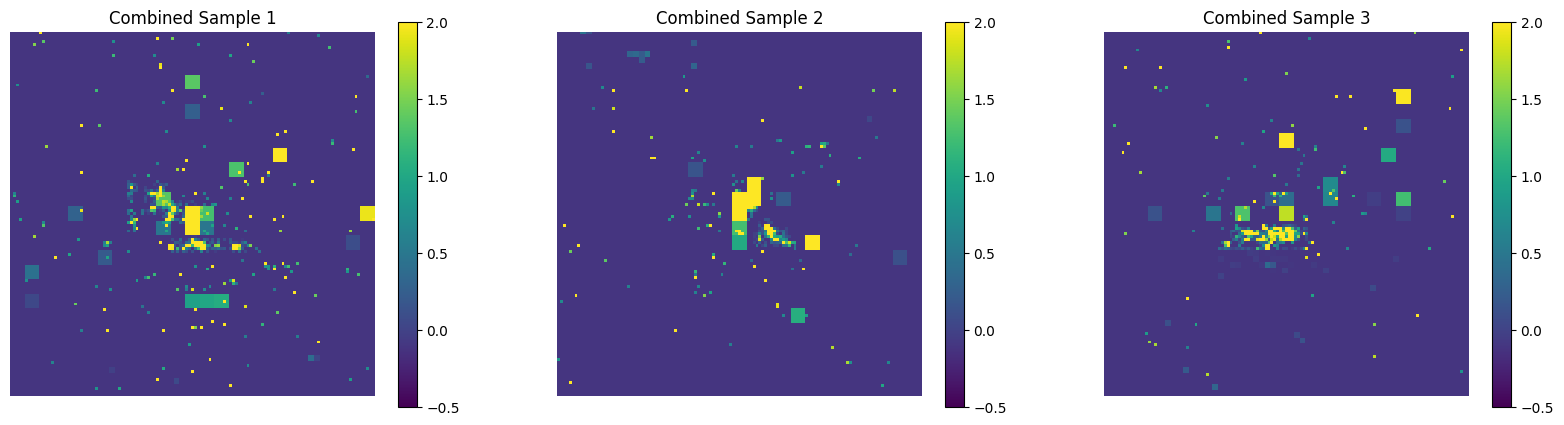

In [6]:
# Select number of images to display
num_images = 3

# Display original images from X_jets
fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 20))
for i in range(3):
    temp = axes[i].imshow(combined[i], cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    axes[i].axis('off')
    axes[i].set_title('Combined Sample {}'.format(i+1))
    fig.colorbar(temp, ax=axes[i], shrink=0.25)
        

In [7]:
class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        
        self.images = X_jets
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image

In [8]:
#Resizing to (64, 64, 3) as training process took up a lot of time and memory
from tensorflow.keras.preprocessing.image import smart_resize

X_jets_resized = np.zeros((X_jets.shape[0], 64, 64, 3))
for i in range(X_jets.shape[0]):
    X_jets_resized[i] = smart_resize(X_jets[i], (64, 64))

X_jets = X_jets_resized
del(X_jets_resized)
print(X_jets.shape)

(6400, 64, 64, 3)


In [9]:
# IMG_SIZE = 128
# IMG_SIZE = 125
IMG_SIZE = 64
BATCH_SIZE = 128

def minmax_norm(img):
    min_val = np.min(img)
    max_val = np.max(img)
    img = ((img - min_val) / (max_val - min_val))  #* 255  # Multiplication by 255 needed if later transformation conversion to PIL image required float32 to be converted to uint8
    
    return img #.astype(np.uint8)

data_transforms = transforms.Compose([
    # transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Lambda(minmax_norm),             #Applying min-max normalization
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

data = CustomDataset(data_path='/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5', transform=data_transforms)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)


In [10]:
item = next(iter(train_loader))[0]
print(item.shape)
print(type(item))
print(type(train_loader))

# print(item)
# print(np.unique(item.numpy()))

torch.Size([3, 64, 64])
<class 'torch.Tensor'>
<class 'torch.utils.data.dataloader.DataLoader'>


# Diffusion Model

## Forward process

In [11]:
def linear_beta_schedule(timesteps, start=0.00000001, end=0.000002):   #start and end need to be carefully chosen
    return torch.linspace(start, end, timesteps) 

def get_index_from_list(vals, t, x_shape):    # Returns a specific index t of a passed list of values vals while considering the batch dimension.
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):   #Take image and timestep and returns noisy version of the image
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )

    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [12]:
for batch_idx, inputs in enumerate(train_loader):
    print(f"Batch {batch_idx}, inputs shape: {inputs.shape}")

for batch_idx, inputs in enumerate(test_loader):
    print(f"Batch {batch_idx}, inputs shape: {inputs.shape}")


Batch 0, inputs shape: torch.Size([128, 3, 64, 64])
Batch 1, inputs shape: torch.Size([128, 3, 64, 64])
Batch 2, inputs shape: torch.Size([128, 3, 64, 64])
Batch 3, inputs shape: torch.Size([128, 3, 64, 64])
Batch 4, inputs shape: torch.Size([128, 3, 64, 64])
Batch 5, inputs shape: torch.Size([128, 3, 64, 64])
Batch 6, inputs shape: torch.Size([128, 3, 64, 64])
Batch 7, inputs shape: torch.Size([128, 3, 64, 64])
Batch 8, inputs shape: torch.Size([128, 3, 64, 64])
Batch 9, inputs shape: torch.Size([128, 3, 64, 64])
Batch 10, inputs shape: torch.Size([128, 3, 64, 64])
Batch 11, inputs shape: torch.Size([128, 3, 64, 64])
Batch 12, inputs shape: torch.Size([128, 3, 64, 64])
Batch 13, inputs shape: torch.Size([128, 3, 64, 64])
Batch 14, inputs shape: torch.Size([128, 3, 64, 64])
Batch 15, inputs shape: torch.Size([128, 3, 64, 64])
Batch 16, inputs shape: torch.Size([128, 3, 64, 64])
Batch 17, inputs shape: torch.Size([128, 3, 64, 64])
Batch 18, inputs shape: torch.Size([128, 3, 64, 64])
Bat

In [13]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),         #Scale from [-1,+1] to [0,1]
        transforms.Normalize(mean=mean, std=std),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(lambda im: np.array(im)),       # convert to NumPy array
    ])
    
    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 

    # image = reverse_transforms(combined)
    image = reverse_transforms(image)

    combined = torch.sum(torch.from_numpy(image), dim=-1, keepdim=True)   # Combine Track, ECAL, and HCAL channels
    
    # print(image.shape)
    # print(type(image))
    # print(image)

    plt.imshow(image, cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')
    plt.imshow(combined, cmap='viridis', vmin=-0.5, vmax=2.0, interpolation='nearest')


<ipython-input-14-daa59ca6ba47>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, math.ceil((idx/stepsize)) + 1)


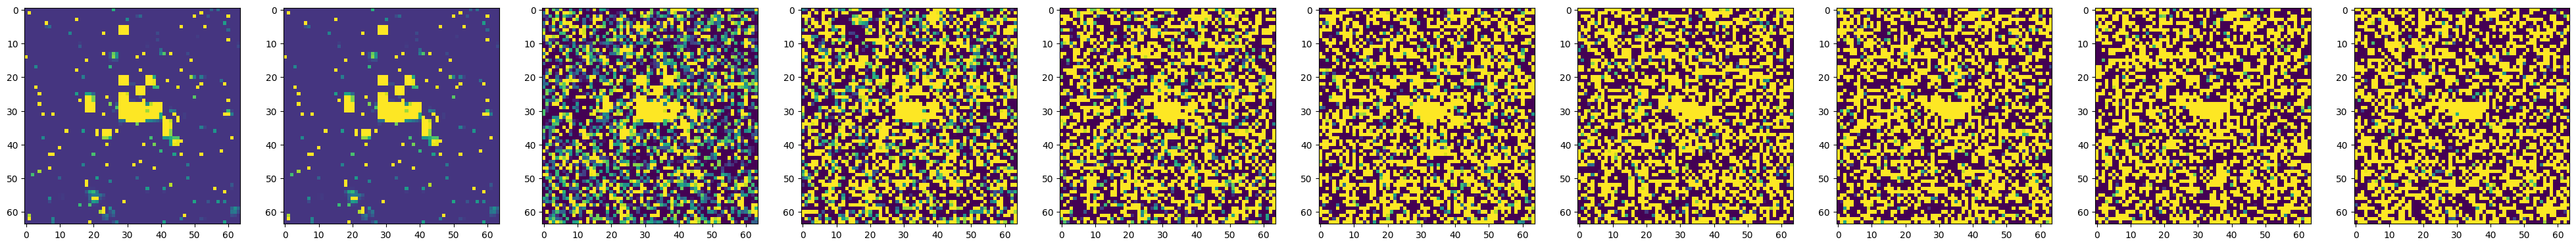

In [14]:
plt.figure(figsize=(55,55))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

# Simulate forward diffusion
image = next(iter(train_loader))[0]

# print(image.type)
show_tensor_image(image)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, math.ceil((idx/stepsize)) + 1)
    show_tensor_image(image)
    image, noise = forward_diffusion_sample(image, t)
    # show_tensor_image(image)

## Backward Process

In [15]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        h = self.bnorm1(self.relu(self.conv1(x)))     # First Conv
        time_emb = self.relu(self.time_mlp(t))         # Time embedding
        time_emb = time_emb[(..., ) + (None, ) * 2]  # Extend last 2 dimensions

        h = h + time_emb       # Add time channel

        h = self.bnorm2(self.relu(self.conv2(h)))      # Second Conv
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3

        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)

        # down_channels = (128, 256, 512, 1024)
        # up_channels = (1024, 512, 256, 128)

        out_dim = 1 
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(                              # Time embedding
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)      # Initial projection


        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # print("Inside forward")
        t = self.time_mlp(timestep)

        x = x.float()    #
        x = self.conv0(x)           # Initial conv

        residual_inputs = []            # Unet
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()

            # print(x.shape)
            # print(residual_x.shape)
            x = torch.cat((x, residual_x), dim=1)       # Add residual x as additional channels  

            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
model

SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [16]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    # print("before calling model")
    noise_pred = model(x_noisy, t)        #Feeding the forward diffused image to the model
    # print("after calling model")
    return F.l1_loss(noise, noise_pred)

In [17]:
@torch.no_grad()
def sample_timestep(x, t):                 # Call model to predict noise in the image and retur denoised image. Apply noise if not yet reached last step.
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    model_mean = sqrt_recip_alphas_t * (                                    # Call model (current image - noise prediction)
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, math.ceil((i/stepsize)) + 1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

## Training 

Epoch 0 | step 000 Training Loss: 0.8094820175681887 


<ipython-input-17-f3ee52b909b7>:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, math.ceil((i/stepsize)) + 1)


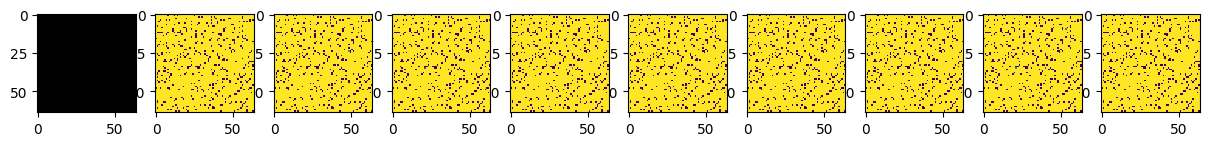

In [18]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 20 

for epoch in range(epochs):
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()

        # print(batch.shape)
        # print(batch[0].shape)
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch, t)
        # loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Training Loss: {loss.item()} ")
            sample_plot_image()
            
      # # Evaluate the model on the test set after each epoch
      # test_loss = 0
      # with torch.no_grad():
      #     for test_step, test_batch in enumerate(test_loader):
      #         test_t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      #         # test_loss += get_loss(model, test_batch[0], test_t).item()
      #         test_loss += get_loss(model, test_batch, test_t).item()
      #     test_loss /= (test_step + 1)
      # print(f"Epoch {epoch} | step {step:03d} Test Loss: {test_loss} ")
          
      # sample_plot_image()


# Discussion

* As dataset images contain physical data rather than RGB values seen in classical images, data preprocessing steps need to be carefully chosen to ensure that the physical properties of the data are not lost during the conversion process. For example, in our case, we had to be careful in scaling the pixel values to avoid losing the relative important features of the image.

*  Given the challenges with using classical image representations for physical data of quark/gluon jet events, alternative representations such as point clouds can be considered which can capture the spatial relationships between the points in a more natural way. 

*  Choice of beta scheduler is crucial, we used linear beta schedule and adjusted start and end values as per manual inspection of step wise forward processed images.

*  Another challenge was in visualizing the intermediate images generated at each step of the diffusion process. Normalization techniques had to be carefully choosen to obtain clear and informative visualizations.

*  For comparison of original and reconstructed events evaluation metrics like structural similarity index (SSIM), or peak signal-to-noise ratio (PSNR) can be used however in my case backward process didnt generate meaningful representations.

*  Further exploration and optimization to achieve high-quality diffusion models for physical data of quark/gluon represented as images is needed. More research is required to investigate different diffusion schedules, data pre-processing techniques, and other model architectures that can better capture the underlying features of the data.




## References

* Denoising Diffusion Probabilistic Models :- https://arxiv.org/pdf/2006.11239.pdf

*  https://github.com/lucidrains/denoising-diffusion-pytorch

*  https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=a30368b2

*  https://medium.com/mlearning-ai/enerating-images-with-ddpms-a-pytorch-implementation-cef5a2ba8cb1